In [1]:
!pip install spacy

In [2]:
! nvidia-smi

Sat Jan 15 22:49:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Modules for languages
# en_core_web_sm - for English
# it_core_news_sm - for Italian
# es_core_news_sm - for Spanish

!python -m spacy download it_core_news_sm

     |████████████████████████████████| 14.5 MB 4.3 MB/s 
  Created wheel for it-core-news-sm: filename=it_core_news_sm-2.2.5-py3-none-any.whl size=14471128 sha256=03d25d8560353bbeb23c3733f97ff2e45a99c1bd8c26ea2d18a8ba94b281979f
  Stored in directory: /tmp/pip-ephem-wheel-cache-eg4x5t93/wheels/87/88/46/36fd0cabbebd89b2ee247bf113c1ca4f2cb184f8b7a6758ba2
Successfully built it-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('it_core_news_sm')


In [4]:
import re
import gensim
import glob
import it_core_news_sm
import pandas as pd
import os
import numpy as np

In [6]:
!pip install contractions

     |████████████████████████████████| 284 kB 4.2 MB/s 
     |████████████████████████████████| 321 kB 43.8 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85445 sha256=b45590da4bc6577cdae54f850a9d5e843030a330fe22e54c4b6ab74c6b4e0605
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [7]:
!pip install unidecode

     |████████████████████████████████| 235 kB 4.2 MB/s 


In [8]:
from datetime import datetime
import codecs
from bs4 import BeautifulSoup
import unidecode
import contractions

In [9]:
def decontracted(phrase):

    phrase = re.sub(r'[^\w.?!;]', ' ', phrase)
    phrase = re.sub(' +', ' ', phrase)
    
    #remove html tags from text
    soup = BeautifulSoup(phrase, "html.parser")
    phrase = soup.get_text(separator=" ")
    
    #remove accented characters from text, e.g. café
    phrase = unidecode.unidecode(phrase)
    
    sentences = re.split('([.;!?] *)', phrase)

    return ' '.join([i.capitalize() for i in  sentences])

In [10]:
def prepare_italy_text(input_path, output_path, error_list,
                         max_len = 5000000, enc = 'utf-8', gutenberg = True, title = ''):
    
    #Italy pipeline optimized for CPU. 
    #Components: tok2vec, morphologizer, parser, senter, ner, attribute_ruler, lemmatizer.
    
    #parser: The dependency parser jointly learns sentence segmentation and labelled dependency parsing, 
    #and can optionally learn to merge tokens that had been over-segmented by the tokenizer.
    
    nlp = it_core_news_sm.load(disable=['parser'])
    nlp.max_length = max_len
    
    pos_dict = {'PROPN': 'PERSON1', 'PRON': 'PRON1', 'NUM': 'ORDINAL1'}

    
    try:
        raw_text = codecs.open(input_path, 'r', enc).read()
    except:
        return -1
    
    if gutenberg:
        begin = raw_text.find('*** START OF THIS PROJECT GUTENBERG EBOOK ')
        begin_2 = begin + 42 + len(title) + 3
        if begin == -1:
                begin = raw_text.find('START OF THE PROJECT GUTENBERG EBOOK ')
                begin_2 = begin + 37 + len(title) + 3

        end = raw_text.find('*** END OF THIS PROJECT GUTENBERG EBOOK')
        if end == -1:
            end = raw_text.find('*** END')
        raw_text = raw_text[begin_2 : end]
        
    
    preprocessed_text = decontracted(raw_text)
    
    nlp_doc = nlp(preprocessed_text)
    sorted_ents = sorted(nlp_doc.ents, key = lambda x: len(x), reverse =  True)


    for ent in sorted_ents:
        preprocessed_text = preprocessed_text.replace(' ' + ent.text + ' ', ' ' + ent.label_+ '1 ')
        
        if not ent.text.islower():
            preprocessed_text = preprocessed_text.replace(' ' + ent.text.lower() + ' ', ' ' + ent.label_+ '1 ')

    new_nlp_doc = nlp(preprocessed_text)
    file_name = path.split('/')[-1]
    

    with open(output_path + file_name, 'w+', ) as prepared_text:
        for token in new_nlp_doc:
            if token.text[-1] != '1':
                if token.pos_ in pos_dict:
                    try:
                        prepared_text.write(pos_dict[token.pos_])
                    except:
                        error_list.append(token.pos_)
                    prepared_text.write('\n')
                    
                        
                    
                elif token.pos_ != 'PUNCT':
                    try:
                        prepared_text.write(token.lemma_.lower())
                    except:
                        error_list.append(token.pos_)
                        
                    prepared_text.write('\n')
                    

            else:
                try:
                    repared_text.write(token.text)
                except:
                        error_list.append(token.pos_)
                prepared_text.write('\n')
    return 1

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# dataframe

dir_books_it = list(glob.glob("/content/drive/MyDrive/2022-01-15_Course_project/books_it/*.txt"))

In [ ]:
len(dir_books_it)

892

In [ ]:
# Example
dir_books_it[0]

'/content/drive/MyDrive/2022-01-15_Course_project/books_it/10215-8.txt'

In [ ]:
dict_book_it = dict()
num = 0

for book in dir_books_it:
    try:
        with open(book) as f:
            lines = f.read()
    
    except:
        try:
            with open(book, encoding="utf8") as f:
                lines = f.read()
        except:
            try:
                lines = codecs.open(book, 'r', 'ISO-8859-1').read()

        
            except:
                dict_s['length'] = -1
                dict_s['ebook_num'] = book.split("\\")[1].split('.')[0]
                dict_s['ebook_dir'] = book

                dict_s['Title'] = ''
                dict_s['Language'] = ''
                dict_s['encoding'] = ''
                dict_book_en[num] = dict_s
                continue
            
        
        
    info_beg = lines.find('Title: ')
    begin = lines.find('*** START OF THIS PROJECT GUTENBERG EBOOK')
    if begin == -1:
            begin = lines.find('START OF THE PROJECT GUTENBERG EBOOK')
            
    end = lines.find('*** END OF THIS PROJECT GUTENBERG EBOOK')
    if end == -1:
        end = lines.find('*** END')
        
    info = lines[info_beg : begin].split('\n')
    dict_s = dict()
    
    for i in info:
            
        if i.find('Title: ') > -1:
            dict_s['Title'] = i.split('Title: ')[1]
            
        if i.find('Language: ') > -1:
            dict_s['Language'] = i.split('Language: ')[1]
            
        if i.find('Character set encoding: ') > -1:
            dict_s['encoding'] = i.split('Character set encoding: ')[1]
            
    with open(book, 'w', encoding='utf8') as fn:
        fn.write(lines)
             
    dict_s['length'] = len(lines[begin : end].split(' '))
    dict_s['ebook_num'] = book.split("/")[-1].split('.txt')[0]
    dict_s['ebook_dir'] = book
    dict_book_it[num] = dict_s
    num += 1

In [ ]:
file_list = pd.DataFrame(dict_book_it.values())
file_list.head()

,Title,Language,length,ebook_num,ebook_dir,encoding
0,Manfredo Palavicino,Italian,181915,10215-8,/content/drive/MyDrive/2022-01-15_Course_proje...,NaN
1,Vecchie Storie,Italian,24082,10502-8,/content/drive/MyDrive/2022-01-15_Course_proje...,ISO-8859-1
2,Compendio di Chimica Fisiologica,Italian,17568,11206-8,/content/drive/MyDrive/2022-01-15_Course_proje...,ISO-8859-1
3,La Campagna del 1796 nel Veneto,Italian,41110,11305-8,/content/drive/MyDrive/2022-01-15_Course_proje...,ISO-8859-1
4,Il Tenente dei Lancieri,Italian,32521,11492-8,/content/drive/MyDrive/2022-01-15_Course_proje...,ISO-8859-1


In [ ]:
# /content/drive/MyDrive/2022-01-15_Course_project/books_it/
if not os.path.exists('/content/drive/MyDrive/2022-01-15_Course_project/prep_it/'):
    try:
        os.makedirs('/content/drive/MyDrive/2022-01-15_Course_project/prep_it/')
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

In [ ]:
print('max length of book: ', max(file_list['length']))

max length of book:  409625


In [12]:
def make_pieces(file_in, file_out, min_lenght = 1000, gutenberg = True, max_count = None):
    file_list = glob.glob(file_in + '*')
    print('number of files: ', len(file_list))
    list_full = []
    list_error = []
    num_ = 0
    count_ = 0
    
    for file_path in file_list:
        try:
            with open(file_path, 'r') as f:
                text = f.read()
    
        except:
            try:
                with open(file_path, 'r', encoding="utf8") as f:
                    text = f.read()
            except:
                try:
                    text = codecs.open(file_path, 'r', 'ISO-8859-1').read()
                except:
                    list_error.append(file_path)
        
            
        if gutenberg:
            info_beg = text.find('Title: ')
            begin = text.find('*** START OF THIS PROJECT GUTENBERG EBOOK ')
            title = ''
            
            if begin > -1:
                for i in text[info_beg : begin].split('\n'):
                    if i.find('Title: ') > -1:
                        title = i.split('Title: ')[1]
                begin_2 = begin + 42 + len(title) + 3
                
            else:
                begin = text.find('START OF THE PROJECT GUTENBERG EBOOK ')
                for i in text[info_beg : begin].split('\n'):
                    if i.find('Title: ') > -1:
                        title = i.split('Title: ')[1]
                begin_2 = begin + 37 + len(title) + 3

            end = text.find('*** END OF THIS PROJECT GUTENBERG EBOOK')
            if end == -1:
                end = text.find('*** END')
            text = text[begin_2 : end]
            
        text_split = text.split('\n')
        len_text =  len(text_split)
        piece_num = len_text // min_lenght
        #print(piece_num, len_text)
            
        file_name = file_path.split('/')[-1].split('.txt')[0]
        
        if count_ % 500 ==0:
            now = datetime.now()
            dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
            print(dt_string, '| ',  'number of processed files: ' + str(num_), round(num_/len(file_list), 3))
            
        
        if piece_num > 1:
            for i in range(piece_num -1):
                text_cut = ' '.join([s for s in text_split[i*min_lenght : (i+1)*min_lenght]])
                with open(file_out + file_name + '_piece'+str(i)+'.txt', 'w+') as output_file:
                    try:
                        output_file.write(text_cut)
                    except:
                        list_error.append(file_out + file_name + '_piece'+str(i)+'.txt')
        
        text_cut = ' '.join([s for s in text_split[max(piece_num - 1, 0) * min_lenght : ]])
        with open(file_out + file_name + '_piece'+str(piece_num)+'.txt', 'w+') as output_file:
            try:
                output_file.write(text_cut)
                #print(file_name)
            except:
                list_error.append(file_out + file_name + '_piece'+str(piece_num)+'.txt')
            
        if piece_num ==0:
            list_full.append(file_out + file_name + '_piece'+str(piece_num)+'.txt')
        num_ += 1
        count_ += piece_num
        if max_count is not None:
            if max_count < count_:
                print('create max pieces!', count_, '| last file:', file_path)
                break
    return list_full, list_error

In [ ]:
#file_list_cut = [i for i in glob.glob('content/cut_eng/' + '*') if i not in list_not_full]

In [ ]:
file_list.sort_values('length', ascending = False)[:20]

,Title,Language,length,ebook_num,ebook_dir,encoding
882,Il Conte di Monte-Cristo,Italian,409625,65391-0,/content/drive/MyDrive/2022-01-15_Course_proje...,UTF-8
670,"Annali d'Italia, vol. 5",Italian,363238,52377-0,/content/drive/MyDrive/2022-01-15_Course_proje...,UTF-8
696,"Annali d'Italia, vol. 6",Italian,356610,56431-0,/content/drive/MyDrive/2022-01-15_Course_proje...,UTF-8
546,"Gli eretici d'Italia, vol. III",Italian,354578,47278-0,/content/drive/MyDrive/2022-01-15_Course_proje...,UTF-8
570,"Annali d'Italia, vol. 4",Italian,350457,48188-0,/content/drive/MyDrive/2022-01-15_Course_proje...,UTF-8
498,"Annali d'Italia, vol. 3",Italian,348333,46355-0,/content/drive/MyDrive/2022-01-15_Course_proje...,UTF-8
714,"Annali d'Italia, vol. 7",Italian,348244,57549-0,/content/drive/MyDrive/2022-01-15_Course_proje...,UTF-8
422,"Annali d'Italia, vol. 2",Italian,343813,43575-0,/content/drive/MyDrive/2022-01-15_Course_proje...,UTF-8
309,"Annali d'Italia, vol. 1",Italian,338202,39704-8,/content/drive/MyDrive/2022-01-15_Course_proje...,ISO-8859-1
746,"Annali d'Italia, vol. 8",Italian,335113,59580-0,/content/drive/MyDrive/2022-01-15_Course_proje...,UTF-8


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
x = file_list.sort_values('length', ascending = False)['length'].to_list()

In [ ]:
perc_ = np.percentile(x, 99)

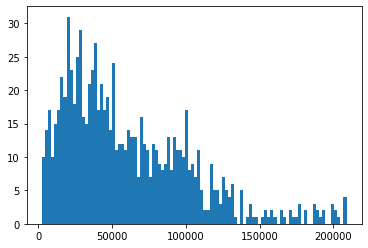

In [ ]:
plt.hist(x[20:], 100)
plt.show()

In [ ]:
sum_len = 0
ind = []
for i in file_list.sort_values('length', ascending = False).index:
    if  file_list.loc[i, 'length'] < perc_:
        sum_len += file_list.loc[i, 'length']
        ind.append(i)
    if sum_len > 20000000:
        break      

In [ ]:
len(ind)

133

In [ ]:
ind_all = [i for i in file_list.sort_values('length', ascending = False).index]

In [ ]:
# Let's process only big files, 
# because there are a lot of small files, which is why processing takes a very long time

tocken_error = []
prepare_book = []

num = 0
book_err = []
sum_len = 0


for i in ind_all:
    if num % 100 == 0:
        now = datetime.now()
        dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
        print(dt_string, '| ',  'number of processed files: ' + str(num), '| count words:', sum_len)
    path = file_list.loc[i, 'ebook_dir']
    
    if file_list.loc[i, 'length'] < perc_ and file_list.loc[i, 'length'] > 1000:
        res = prepare_italy_text(path, '/content/drive/MyDrive/2022-01-15_Course_project/prep_it/', tocken_error,  max_len = 5000000, 
                                   gutenberg = True, title = file_list.loc[i, 'Title'], enc = file_list.loc[i, 'encoding'])
        if res < 0:
            book_err.append(path)
            print('ERROR: ', path)
        else:
            
            prepare_book.append(path)
            sum_len += file_list.loc[i, 'length']
    num += 1
    if sum_len > 20000000:
        break

15/01/2022 15:16:33 |  number of processed files: 0 | count words: 0
ERROR:  /content/drive/MyDrive/2022-01-15_Course_project/books_it/10215-8.txt
15/01/2022 16:08:32 |  number of processed files: 100 | count words: 15180284


In [16]:
list_not_full , list_error = make_pieces('/content/drive/MyDrive/2022-01-15_Course_project/prep_it/', 
                                         '/content/drive/MyDrive/2022-01-15_Course_project/cut_it/', 
                                         min_lenght = 1500, gutenberg = False, max_count = 15000)

number of files:  134
15/01/2022 22:52:05 |  number of processed files: 0 0.0
15/01/2022 22:52:23 |  number of processed files: 14 0.104
15/01/2022 22:52:41 |  number of processed files: 31 0.231


In [29]:
len(glob.glob('/content/drive/MyDrive/2022-01-15_Course_project/cut_it/*'))

14487

In [26]:
with open('/content/drive/MyDrive/2022-01-15_Course_project/cut_it/48114-0_piece152.txt', 'r') as f:
  pppp = f.read()

In [28]:
 len(pppp.split(' '))

1565

# TF-IDF  and dictionary

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
print(stopwords.words('italian'))

['ad', 'al', 'allo', 'ai', 'agli', 'all', 'agl', 'alla', 'alle', 'con', 'col', 'coi', 'da', 'dal', 'dallo', 'dai', 'dagli', 'dall', 'dagl', 'dalla', 'dalle', 'di', 'del', 'dello', 'dei', 'degli', 'dell', 'degl', 'della', 'delle', 'in', 'nel', 'nello', 'nei', 'negli', 'nell', 'negl', 'nella', 'nelle', 'su', 'sul', 'sullo', 'sui', 'sugli', 'sull', 'sugl', 'sulla', 'sulle', 'per', 'tra', 'contro', 'io', 'tu', 'lui', 'lei', 'noi', 'voi', 'loro', 'mio', 'mia', 'miei', 'mie', 'tuo', 'tua', 'tuoi', 'tue', 'suo', 'sua', 'suoi', 'sue', 'nostro', 'nostra', 'nostri', 'nostre', 'vostro', 'vostra', 'vostri', 'vostre', 'mi', 'ti', 'ci', 'vi', 'lo', 'la', 'li', 'le', 'gli', 'ne', 'il', 'un', 'uno', 'una', 'ma', 'ed', 'se', 'perché', 'anche', 'come', 'dov', 'dove', 'che', 'chi', 'cui', 'non', 'più', 'quale', 'quanto', 'quanti', 'quanta', 'quante', 'quello', 'quelli', 'quella', 'quelle', 'questo', 'questi', 'questa', 'queste', 'si', 'tutto', 'tutti', 'a', 'c', 'e', 'i', 'l', 'o', 'ho', 'hai', 'ha', 'ab

In [42]:
def make_corpus(input_path, output_file_path):
    i = 0
    file_list = glob.glob(input_path + '*')
    
    with open(output_file_path, 'w+') as output_file:
        for file in file_list:
            if i % 100 == 0:
                now = datetime.now()
                dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
                print(dt_string, '| ',  'number of processed files: ' + str(i), '| ', 
                      'percentage of completion:', str(round(i/len(file_list), 2)* 100) + ' %' )
            i+=1
            with open(file, 'r') as input_file:
                output_file.write(input_file.read().replace('\n', ' '))
                output_file.write('\n')

In [43]:
make_corpus('/content/drive/MyDrive/2022-01-15_Course_project/cut_it/', 
            '/content/drive/MyDrive/2022-01-15_Course_project/italy_corpus.txt') 

15/01/2022 23:08:25 |  number of processed files: 0 |  percentage of completion: 0.0 %
15/01/2022 23:08:25 |  number of processed files: 100 |  percentage of completion: 1.0 %
15/01/2022 23:08:33 |  number of processed files: 200 |  percentage of completion: 1.0 %
15/01/2022 23:08:34 |  number of processed files: 300 |  percentage of completion: 2.0 %
15/01/2022 23:08:34 |  number of processed files: 400 |  percentage of completion: 3.0 %
15/01/2022 23:08:34 |  number of processed files: 500 |  percentage of completion: 3.0 %
15/01/2022 23:08:34 |  number of processed files: 600 |  percentage of completion: 4.0 %
15/01/2022 23:08:34 |  number of processed files: 700 |  percentage of completion: 5.0 %
15/01/2022 23:08:34 |  number of processed files: 800 |  percentage of completion: 6.0 %
15/01/2022 23:08:34 |  number of processed files: 900 |  percentage of completion: 6.0 %
15/01/2022 23:08:34 |  number of processed files: 1000 |  percentage of completion: 7.000000000000001 %
15/01/20

In [44]:
def make_table_and_dict(corpus_path, min_df, max_df, token_pattern = None, use_idf = True, stop_words = 'italian'):
    
    with open(corpus_path, 'r') as corpus_file:
        if token_pattern:
            vectorizer = TfidfVectorizer(analyzer='word', min_df=min_df, token_pattern=token_pattern, use_idf=use_idf)
        else:
            vectorizer = TfidfVectorizer(analyzer='word', min_df=min_df)
        data_vectorized = vectorizer.fit_transform(corpus_file)
    return data_vectorized, vectorizer.get_feature_names(), vectorizer.idf_

In [45]:
it_data_vectorized, it_dictionary, it_idfs = make_table_and_dict('/content/drive/MyDrive/2022-01-15_Course_project/italy_corpus.txt', 
                                                                 0.01,  0.8,
                                                                 token_pattern = '[A-Za-z]+',
                                                                 stop_words = stopwords.words('italian'))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [46]:
len(it_dictionary)

5915

In [47]:
it_data_vectorized.shape

(14487, 5915)

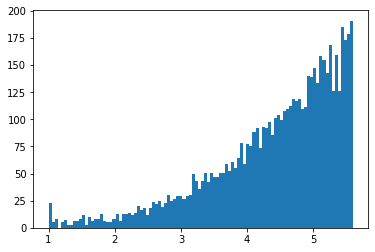

In [48]:
plt.hist(it_idfs, bins = 100)
plt.show()

In [49]:
max(it_idfs)

5.597469377854913

In [50]:
pairs = list(zip(it_dictionary, it_idfs))
sorted(pairs, key = lambda x: x[1])

[('person', 1.0),
 ('pron', 1.0006904647101627),
 ('a', 1.002072826003007),
 ('in', 1.0032493374366842),
 ('ordinal', 1.0035263649334347),
 ('per', 1.0078997015348614),
 ('e', 1.0084564169285024),
 ('il', 1.009292071573232),
 ('non', 1.0103376228482102),
 ('la', 1.0104073651504317),
 ('di', 1.0106166212457792),
 ('da', 1.0165638138664528),
 ('un', 1.0186712962060176),
 ('l', 1.0188119530738209),
 ('essere', 1.0188822889275513),
 ('del', 1.020219610963918),
 ('suo', 1.0229702562782785),
 ('che', 1.0240302146858244),
 ('fare', 1.0294180059693763),
 ('avere', 1.0305559861775315),
 ('con', 1.0309118707323395),
 ('una', 1.0345491460756706),
 ('ma', 1.0387735464437395),
 ('come', 1.0539560243115897),
 ('della', 1.055778913000405),
 ('al', 1.065606641531565),
 ('questo', 1.0691506499662942),
 ('se', 1.0782152784950363),
 ('ed', 1.1042261203680865),
 ('ad', 1.1058361180325296),
 ('o', 1.107371862786492),
 ('altro', 1.1099880538754905),
 ('potere', 1.1118389065670389),
 ('alla', 1.1226263302551